In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [5]:
transform_specs = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))]
)

data = torchvision.datasets.MNIST(root="./root", train=True, download=True, transform=transform_specs)
data = DataLoader(data, batch_size=128, shuffle=True)

In [6]:
class Generator(nn.Module):
    def __init__(self, z_dim = 100, img_channels = 1, img_weight=28, img_height=28):
        super(Generator, self).__init__()

        self.img_channels = img_channels
        self.img_weight = img_weight
        self.img_height = img_height

        self.model = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, img_channels*img_weight*img_height),
            nn.Tanh()
        )
    
    def forward(self, z):

        img = self.model(z)
        img = img.view(img.size(0), self.img_channels, self.img_weight, self.img_height)
        
        return img

In [7]:
class Discriminator(nn.Module):
    def __init__(self, img_channels = 1, img_weight=28, img_height=28):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(img_channels*img_weight*img_height, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024,512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512,256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256,1),
            nn.Sigmoid()
        )

    def forward(self, img):

        return self.model(img) 

In [ ]:
loss = nn.BCELoss()

generator = Generator(z_dim=100)
discriminator = Discriminator()

optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator.to(device)
discriminator.to(device)

Discriminator(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=1024, bias=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=512, out_features=256, bias=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Linear(in_features=256, out_features=1, bias=True)
    (8): Sigmoid()
  )
)

In [ ]:
def generate_and_show_images(generator, epoch_num):
    fixed_noise = torch.randn(25, 100).to(device)
    generator.eval() 
    with torch.no_grad():
        generated_images = generator(fixed_noise).cpu()

    generated_images = generated_images * 0.5 + 0.5

    fig = plt.figure(figsize=(5, 5))
    plt.suptitle(f"Epoch {epoch_num} Sonu Üretilen Görüntüler", fontsize=16)
    
    for i in range(generated_images.shape[0]):
        ax = fig.add_subplot(5, 5, i + 1)
        img = generated_images[i].squeeze().numpy() 
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        
    plt.show()
    
    generator.train()

def train(generator, discriminator, data, epochs=10):
    
    for epoch in range(epochs):
        for i, (img, label) in enumerate(data):

            real_imgs = img.to(device)
            batch_size = real_imgs.size(0)
            valid = torch.ones(batch_size,1).to(device)
            fake = torch.zeros(batch_size,1).to(device)

            # train discriminator
            optimizer_d.zero_grad()
            real_loss = loss(discriminator(real_imgs), valid)

            fake_loss = loss(discriminator(generator(torch.randn(batch_size,100).to(device)).detach()), fake)
            d_loss = (real_loss + fake_loss) /2
            d_loss.backward()
            optimizer_d.step()

            # train generator

            optimizer_g.zero_grad()
            g_loss = loss(discriminator(generator(torch.randn(batch_size,100).to(device))),valid)
            g_loss.backward()
            optimizer_g.step()

            if i % 50 == 0:
                print(f"epoch: {epoch/epochs} batch: {i}/{(len(data))} d_loss: {d_loss.item()} g_loss: {g_loss.item()}")
        
        generate_and_show_images(generator, epoch)

epoch: 0.0 batch: 0/469 d_loss: 0.6405603289604187 g_loss: 3.052412986755371
epoch: 0.0 batch: 50/469 d_loss: 0.4476475417613983 g_loss: 1.4463748931884766
epoch: 0.0 batch: 100/469 d_loss: 0.4989287853240967 g_loss: 1.0448694229125977
epoch: 0.0 batch: 150/469 d_loss: 0.44988685846328735 g_loss: 1.3776057958602905
epoch: 0.0 batch: 200/469 d_loss: 0.47231990098953247 g_loss: 1.3361179828643799
epoch: 0.0 batch: 250/469 d_loss: 0.4221281409263611 g_loss: 1.4479258060455322
epoch: 0.0 batch: 300/469 d_loss: 0.5036912560462952 g_loss: 1.4784044027328491
epoch: 0.0 batch: 350/469 d_loss: 0.44444966316223145 g_loss: 1.44712233543396
epoch: 0.0 batch: 400/469 d_loss: 0.5709280967712402 g_loss: 2.328676700592041
epoch: 0.0 batch: 450/469 d_loss: 0.44937044382095337 g_loss: 1.4399086236953735


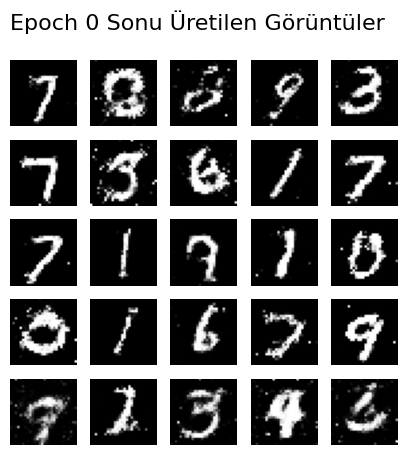

epoch: 0.1 batch: 0/469 d_loss: 0.5005120038986206 g_loss: 1.043837070465088
epoch: 0.1 batch: 50/469 d_loss: 0.6762673258781433 g_loss: 1.1455790996551514
epoch: 0.1 batch: 100/469 d_loss: 0.451077938079834 g_loss: 1.6586995124816895
epoch: 0.1 batch: 150/469 d_loss: 0.4925386309623718 g_loss: 2.781364917755127
epoch: 0.1 batch: 200/469 d_loss: 0.4923546314239502 g_loss: 1.0756014585494995
epoch: 0.1 batch: 250/469 d_loss: 0.47622454166412354 g_loss: 1.4488526582717896
epoch: 0.1 batch: 300/469 d_loss: 0.40699243545532227 g_loss: 1.5663405656814575
epoch: 0.1 batch: 350/469 d_loss: 0.44695180654525757 g_loss: 1.564069151878357
epoch: 0.1 batch: 400/469 d_loss: 0.38939666748046875 g_loss: 1.5840327739715576
epoch: 0.1 batch: 450/469 d_loss: 0.4129667282104492 g_loss: 1.3573212623596191


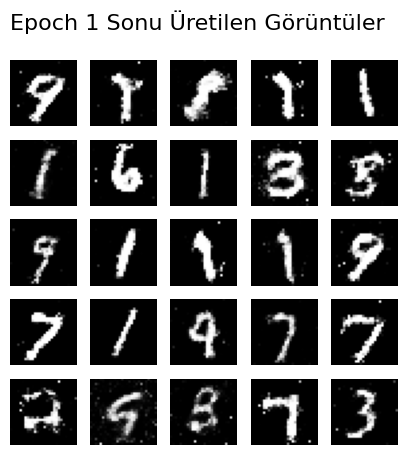

epoch: 0.2 batch: 0/469 d_loss: 0.4517490863800049 g_loss: 1.0829200744628906
epoch: 0.2 batch: 50/469 d_loss: 0.5217352509498596 g_loss: 2.4982452392578125
epoch: 0.2 batch: 100/469 d_loss: 0.4581335783004761 g_loss: 1.5360703468322754
epoch: 0.2 batch: 150/469 d_loss: 0.6669643521308899 g_loss: 1.1452581882476807
epoch: 0.2 batch: 200/469 d_loss: 0.42297253012657166 g_loss: 1.1834197044372559
epoch: 0.2 batch: 250/469 d_loss: 0.3834768533706665 g_loss: 1.3057312965393066
epoch: 0.2 batch: 300/469 d_loss: 0.44456422328948975 g_loss: 1.3740224838256836
epoch: 0.2 batch: 350/469 d_loss: 0.4558311998844147 g_loss: 1.730830430984497
epoch: 0.2 batch: 400/469 d_loss: 0.5320154428482056 g_loss: 1.9833087921142578
epoch: 0.2 batch: 450/469 d_loss: 0.41175365447998047 g_loss: 1.4571161270141602


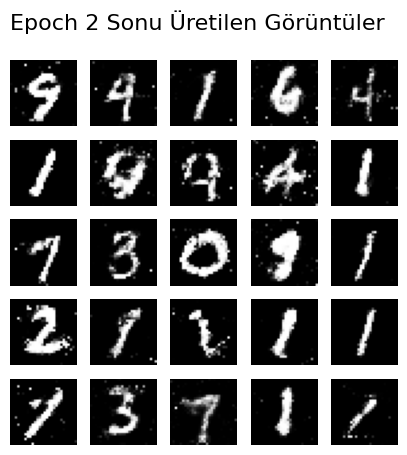

epoch: 0.3 batch: 0/469 d_loss: 0.5466426610946655 g_loss: 1.7305545806884766
epoch: 0.3 batch: 50/469 d_loss: 0.4321870803833008 g_loss: 1.6471126079559326
epoch: 0.3 batch: 100/469 d_loss: 0.4607950747013092 g_loss: 1.4388749599456787
epoch: 0.3 batch: 150/469 d_loss: 0.44111061096191406 g_loss: 1.0761504173278809
epoch: 0.3 batch: 200/469 d_loss: 0.47712185978889465 g_loss: 1.0550994873046875
epoch: 0.3 batch: 250/469 d_loss: 0.4647381901741028 g_loss: 1.447967290878296
epoch: 0.3 batch: 300/469 d_loss: 0.45532459020614624 g_loss: 1.5337963104248047
epoch: 0.3 batch: 350/469 d_loss: 0.46956005692481995 g_loss: 1.4367191791534424
epoch: 0.3 batch: 400/469 d_loss: 0.43764054775238037 g_loss: 1.6332732439041138
epoch: 0.3 batch: 450/469 d_loss: 0.4304550290107727 g_loss: 1.4882646799087524


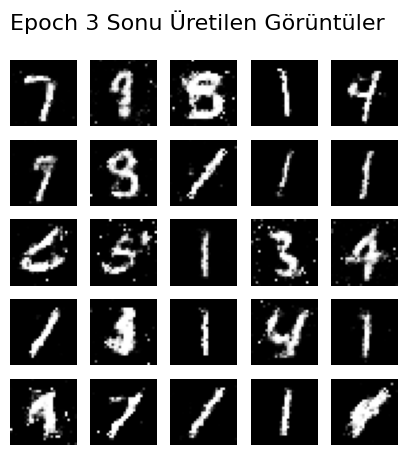

epoch: 0.4 batch: 0/469 d_loss: 0.43306952714920044 g_loss: 1.1411795616149902
epoch: 0.4 batch: 50/469 d_loss: 0.42679518461227417 g_loss: 1.6605000495910645
epoch: 0.4 batch: 100/469 d_loss: 0.4648441970348358 g_loss: 1.4095748662948608
epoch: 0.4 batch: 150/469 d_loss: 0.48905330896377563 g_loss: 1.8676040172576904
epoch: 0.4 batch: 200/469 d_loss: 0.537216067314148 g_loss: 1.4102414846420288
epoch: 0.4 batch: 250/469 d_loss: 0.46540558338165283 g_loss: 1.1456869840621948
epoch: 0.4 batch: 300/469 d_loss: 0.4591106176376343 g_loss: 1.5248088836669922
epoch: 0.4 batch: 350/469 d_loss: 0.47645241022109985 g_loss: 1.4305541515350342
epoch: 0.4 batch: 400/469 d_loss: 0.5266754627227783 g_loss: 1.9539539813995361
epoch: 0.4 batch: 450/469 d_loss: 0.5491400957107544 g_loss: 2.101792812347412


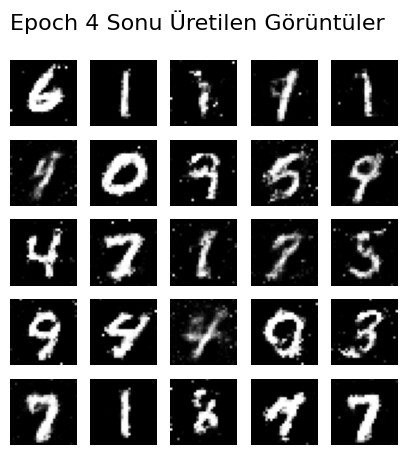

epoch: 0.5 batch: 0/469 d_loss: 0.4449785351753235 g_loss: 1.455651044845581
epoch: 0.5 batch: 50/469 d_loss: 0.46928855776786804 g_loss: 1.0877283811569214
epoch: 0.5 batch: 100/469 d_loss: 0.5418106913566589 g_loss: 1.9739019870758057
epoch: 0.5 batch: 150/469 d_loss: 0.47349464893341064 g_loss: 1.6118189096450806
epoch: 0.5 batch: 200/469 d_loss: 0.4525146484375 g_loss: 1.541008710861206
epoch: 0.5 batch: 250/469 d_loss: 0.49065399169921875 g_loss: 1.5861401557922363
epoch: 0.5 batch: 300/469 d_loss: 0.4735763967037201 g_loss: 0.9611524343490601
epoch: 0.5 batch: 350/469 d_loss: 0.46260973811149597 g_loss: 1.313516616821289
epoch: 0.5 batch: 400/469 d_loss: 0.4687551259994507 g_loss: 1.64461088180542
epoch: 0.5 batch: 450/469 d_loss: 0.6788590550422668 g_loss: 0.6994134187698364


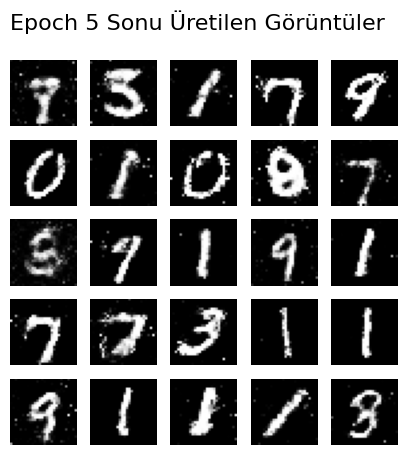

epoch: 0.6 batch: 0/469 d_loss: 0.4096055030822754 g_loss: 1.2494966983795166
epoch: 0.6 batch: 50/469 d_loss: 0.4286942481994629 g_loss: 1.1756842136383057
epoch: 0.6 batch: 100/469 d_loss: 0.38127124309539795 g_loss: 1.5093085765838623
epoch: 0.6 batch: 150/469 d_loss: 0.44040483236312866 g_loss: 1.7627925872802734
epoch: 0.6 batch: 200/469 d_loss: 0.47473758459091187 g_loss: 1.629658579826355
epoch: 0.6 batch: 250/469 d_loss: 0.4798462688922882 g_loss: 1.0977988243103027
epoch: 0.6 batch: 300/469 d_loss: 0.4688345193862915 g_loss: 1.1580748558044434
epoch: 0.6 batch: 350/469 d_loss: 0.5048379302024841 g_loss: 1.0199273824691772
epoch: 0.6 batch: 400/469 d_loss: 0.4946306347846985 g_loss: 1.3859013319015503
epoch: 0.6 batch: 450/469 d_loss: 0.45557886362075806 g_loss: 1.5295562744140625


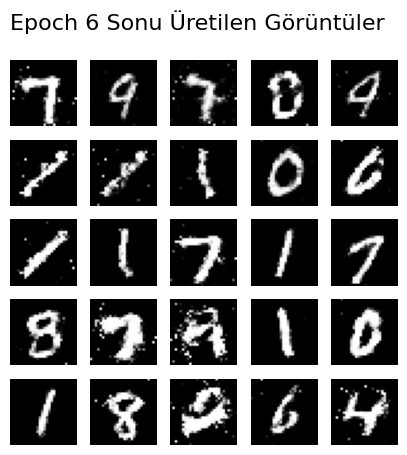

epoch: 0.7 batch: 0/469 d_loss: 0.4937383532524109 g_loss: 1.2898808717727661
epoch: 0.7 batch: 50/469 d_loss: 0.4276919364929199 g_loss: 1.1916606426239014
epoch: 0.7 batch: 100/469 d_loss: 0.4723888635635376 g_loss: 1.5280113220214844
epoch: 0.7 batch: 150/469 d_loss: 0.49056681990623474 g_loss: 1.5166326761245728
epoch: 0.7 batch: 200/469 d_loss: 0.41084742546081543 g_loss: 1.5639722347259521
epoch: 0.7 batch: 250/469 d_loss: 0.45846840739250183 g_loss: 1.547140121459961
epoch: 0.7 batch: 300/469 d_loss: 0.47260475158691406 g_loss: 1.2376465797424316
epoch: 0.7 batch: 350/469 d_loss: 0.41735413670539856 g_loss: 1.6701226234436035
epoch: 0.7 batch: 400/469 d_loss: 0.45703983306884766 g_loss: 1.8014854192733765
epoch: 0.7 batch: 450/469 d_loss: 0.5276374816894531 g_loss: 0.7954244017601013


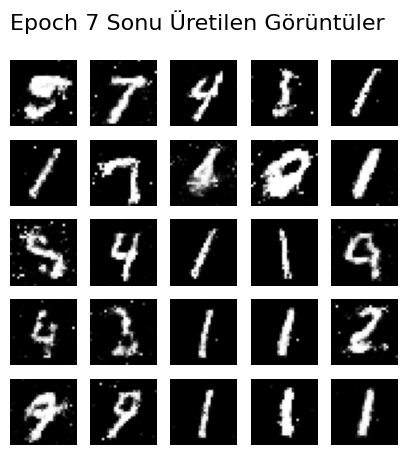

epoch: 0.8 batch: 0/469 d_loss: 0.46160274744033813 g_loss: 1.640570878982544
epoch: 0.8 batch: 50/469 d_loss: 0.47274690866470337 g_loss: 1.2393701076507568
epoch: 0.8 batch: 100/469 d_loss: 0.5223180651664734 g_loss: 1.8811179399490356
epoch: 0.8 batch: 150/469 d_loss: 0.45143207907676697 g_loss: 1.236364722251892
epoch: 0.8 batch: 200/469 d_loss: 0.5037741661071777 g_loss: 1.5772950649261475
epoch: 0.8 batch: 250/469 d_loss: 0.4367794394493103 g_loss: 1.3384153842926025
epoch: 0.8 batch: 300/469 d_loss: 0.5130904912948608 g_loss: 1.6984291076660156
epoch: 0.8 batch: 350/469 d_loss: 0.49535447359085083 g_loss: 0.8704755902290344
epoch: 0.8 batch: 400/469 d_loss: 0.48923033475875854 g_loss: 1.6501519680023193
epoch: 0.8 batch: 450/469 d_loss: 0.466217577457428 g_loss: 1.422662615776062


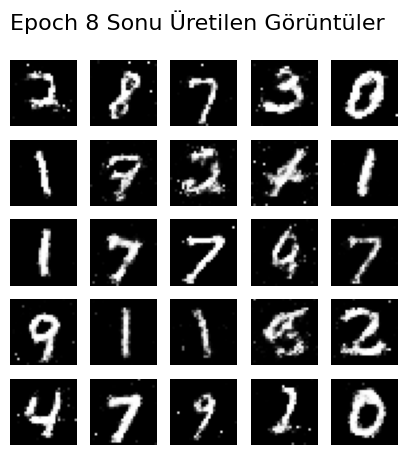

epoch: 0.9 batch: 0/469 d_loss: 0.5143528580665588 g_loss: 1.5973016023635864
epoch: 0.9 batch: 50/469 d_loss: 0.5206744074821472 g_loss: 1.326326847076416
epoch: 0.9 batch: 100/469 d_loss: 0.5664666891098022 g_loss: 1.3530068397521973
epoch: 0.9 batch: 150/469 d_loss: 0.48295658826828003 g_loss: 1.2757971286773682
epoch: 0.9 batch: 200/469 d_loss: 0.4667726159095764 g_loss: 1.7379021644592285
epoch: 0.9 batch: 250/469 d_loss: 0.42342984676361084 g_loss: 1.3359872102737427
epoch: 0.9 batch: 300/469 d_loss: 0.513738751411438 g_loss: 1.1397161483764648
epoch: 0.9 batch: 350/469 d_loss: 0.44921743869781494 g_loss: 1.0479583740234375
epoch: 0.9 batch: 400/469 d_loss: 0.4440739154815674 g_loss: 1.062140703201294
epoch: 0.9 batch: 450/469 d_loss: 0.4620577394962311 g_loss: 1.3670523166656494


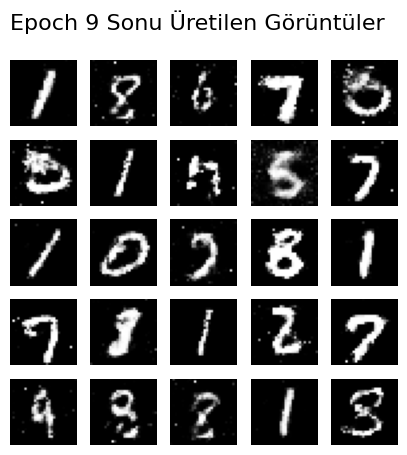

In [18]:
train(generator, discriminator, data, 10)